In [1]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import torch
import numpy as np

from data import Burgers_Dataset
from unet2d import Unet2D
from diffuser import GaussianDiffusion

ModuleNotFoundError: No module named 'data'

In [2]:
ds = Burgers_Dataset("../data/burgers_data_Nt100_v1e-02_N200.mat", normalize=False)

Loaded 200 samples from ../data/burgers_data_Nt100_v1e-02_N200.mat
Shape of x: torch.Size([200, 1, 100, 128])


In [11]:
ds.a.shape

torch.Size([200, 1, 128])

In [12]:
ds.u.shape

torch.Size([200, 1, 100, 128])

### Visualization of the Physical Process

In [3]:
x_range = torch.linspace(0, 1, 128+1)[:-1]
t_range = torch.linspace(0, 1, 100+1)
X, T = torch.meshgrid(x_range, t_range, indexing='ij')

In [14]:
u0 = ds.a[24]
u_traj = ds.u[24, 0]
u = torch.cat([u0, u_traj], dim=0)
u = u.permute(1, 0)

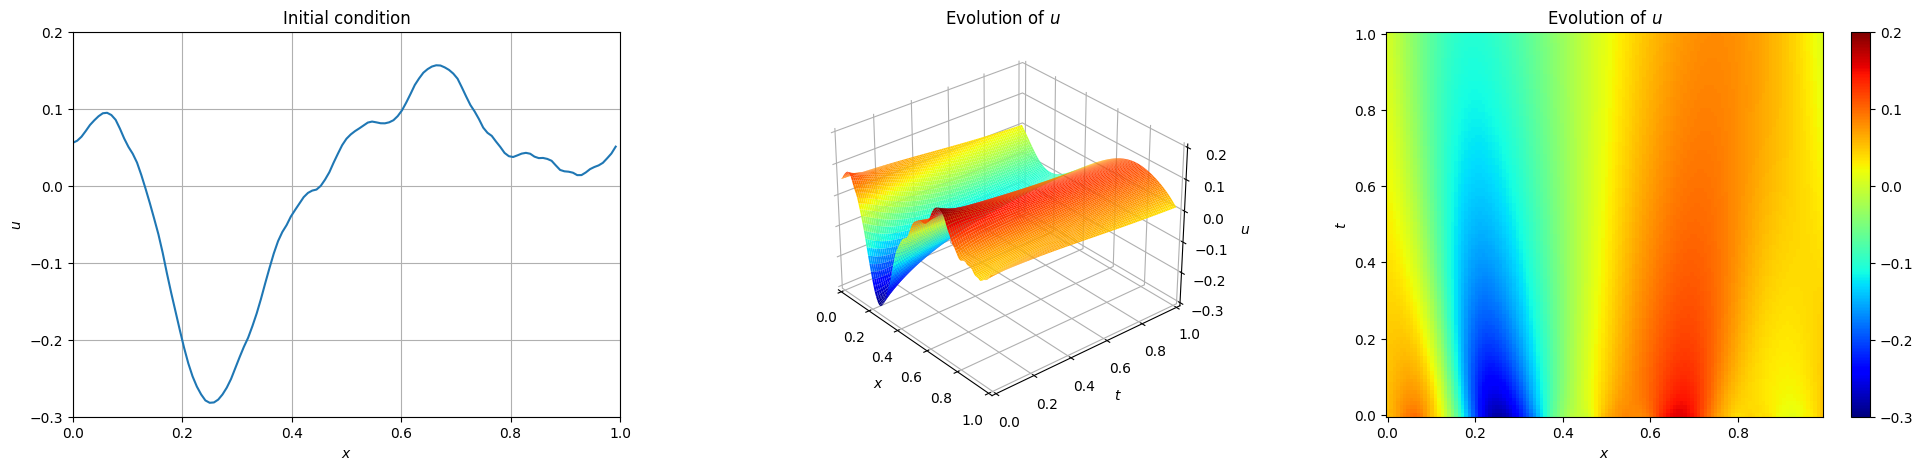

In [36]:
norm = matplotlib.colors.Normalize(vmin=-0.3, vmax=0.2)
fig = plt.figure(figsize=(24, 5))
ax1 = fig.add_subplot(131)
ax1.plot(x_range, u0.squeeze())
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u$')
ax1.set_xlim([0, 1])
ax1.set_ylim([-0.3, 0.2])
ax1.grid()
ax1.set_title('Initial condition')

ax2 = fig.add_subplot(132, projection='3d')
im2 = ax2.plot_surface(X, T, u, cmap='jet', rstride=1, cstride=1)
ax2.view_init(30, -40)
ax2.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_zlim([-0.3, 0.2])
ax2.set_xlabel('$x$')
ax2.set_ylabel('$t$')
ax2.set_zlabel('$u$')
ax2.set_title('Evolution of $u$')
# fig.colorbar(im2, ax=ax2)

ax3 = fig.add_subplot(133)
im3 = ax3.pcolormesh(X, T, u, cmap='jet', norm=norm)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$t$')
ax3.set_title('Evolution of $u$')
fig.colorbar(im3, ax=ax3)
plt.show()

In [37]:
fig.savefig('../assets/burgers/burges_visualization.png', dpi=300)

### Model Test

In [4]:
device = torch.device('cuda:0')

In [5]:
model = Unet2D(
    channels=1,
    cond_channels=1,
    channel_mults=(1, 2, 4, 8),
    init_conv_channels=32,
    init_conv_kernel_size=5
)
diffusion_model = GaussianDiffusion(
    model=model,
    sample_size=(1, 100, 128),
    timesteps=800,
    objective='pred_x0',
    physics_loss_weight=0.0
).to(device)

In [5]:
x = ds[-12:]['x']
y = ds[-12:]['y']

In [8]:
def make_prediction(diffusion_model, cond, physics_loss_weight, error_calibration=False):
    if error_calibration and physics_loss_weight > 0.0:
        weights = torch.load(f"../ckpts/ddpm/burgers_{physics_loss_weight:.2f}phyloss(ec)/ckpt_clean.pt", map_location={'cuda:1':'cuda:0'})
    else:
        weights = torch.load(f"../ckpts/ddpm/burgers_{physics_loss_weight:.2f}phyloss/ckpt_clean.pt", map_location={'cuda:1':'cuda:0'})
    diffusion_model.model.load_state_dict(weights)
    x_pred = diffusion_model.sample(cond=cond)

    return x_pred.cpu().numpy().squeeze()

In [7]:
# x_pred000 = make_prediction(diffusion_model, y, 0.0, False)
# x_pred005 = make_prediction(diffusion_model, y, 0.05, False)
# x_pred010 = make_prediction(diffusion_model, y, 0.1, False)
# x_pred020 = make_prediction(diffusion_model, y, 0.2, False)
# # x_pred000_cal = make_prediction(diffusion_model, y, 0.0, True)
x_pred005_cal = make_prediction(diffusion_model, y, 0.05, True)
# x_pred010_cal = make_prediction(diffusion_model, y, 0.1, True)
# x_pred020_cal = make_prediction(diffusion_model, y, 0.2, True)

DDPM sampling: 100%|██████████| 800/800 [01:38<00:00,  8.10it/s]


In [14]:
x_range = torch.linspace(0, 1, 128+1)[:-1]
t_range = torch.linspace(0, 1, 100+1)[1:]
X, T = torch.meshgrid(x_range, t_range, indexing='ij')

In [9]:
x = x.numpy().squeeze()
y = y.numpy().squeeze()

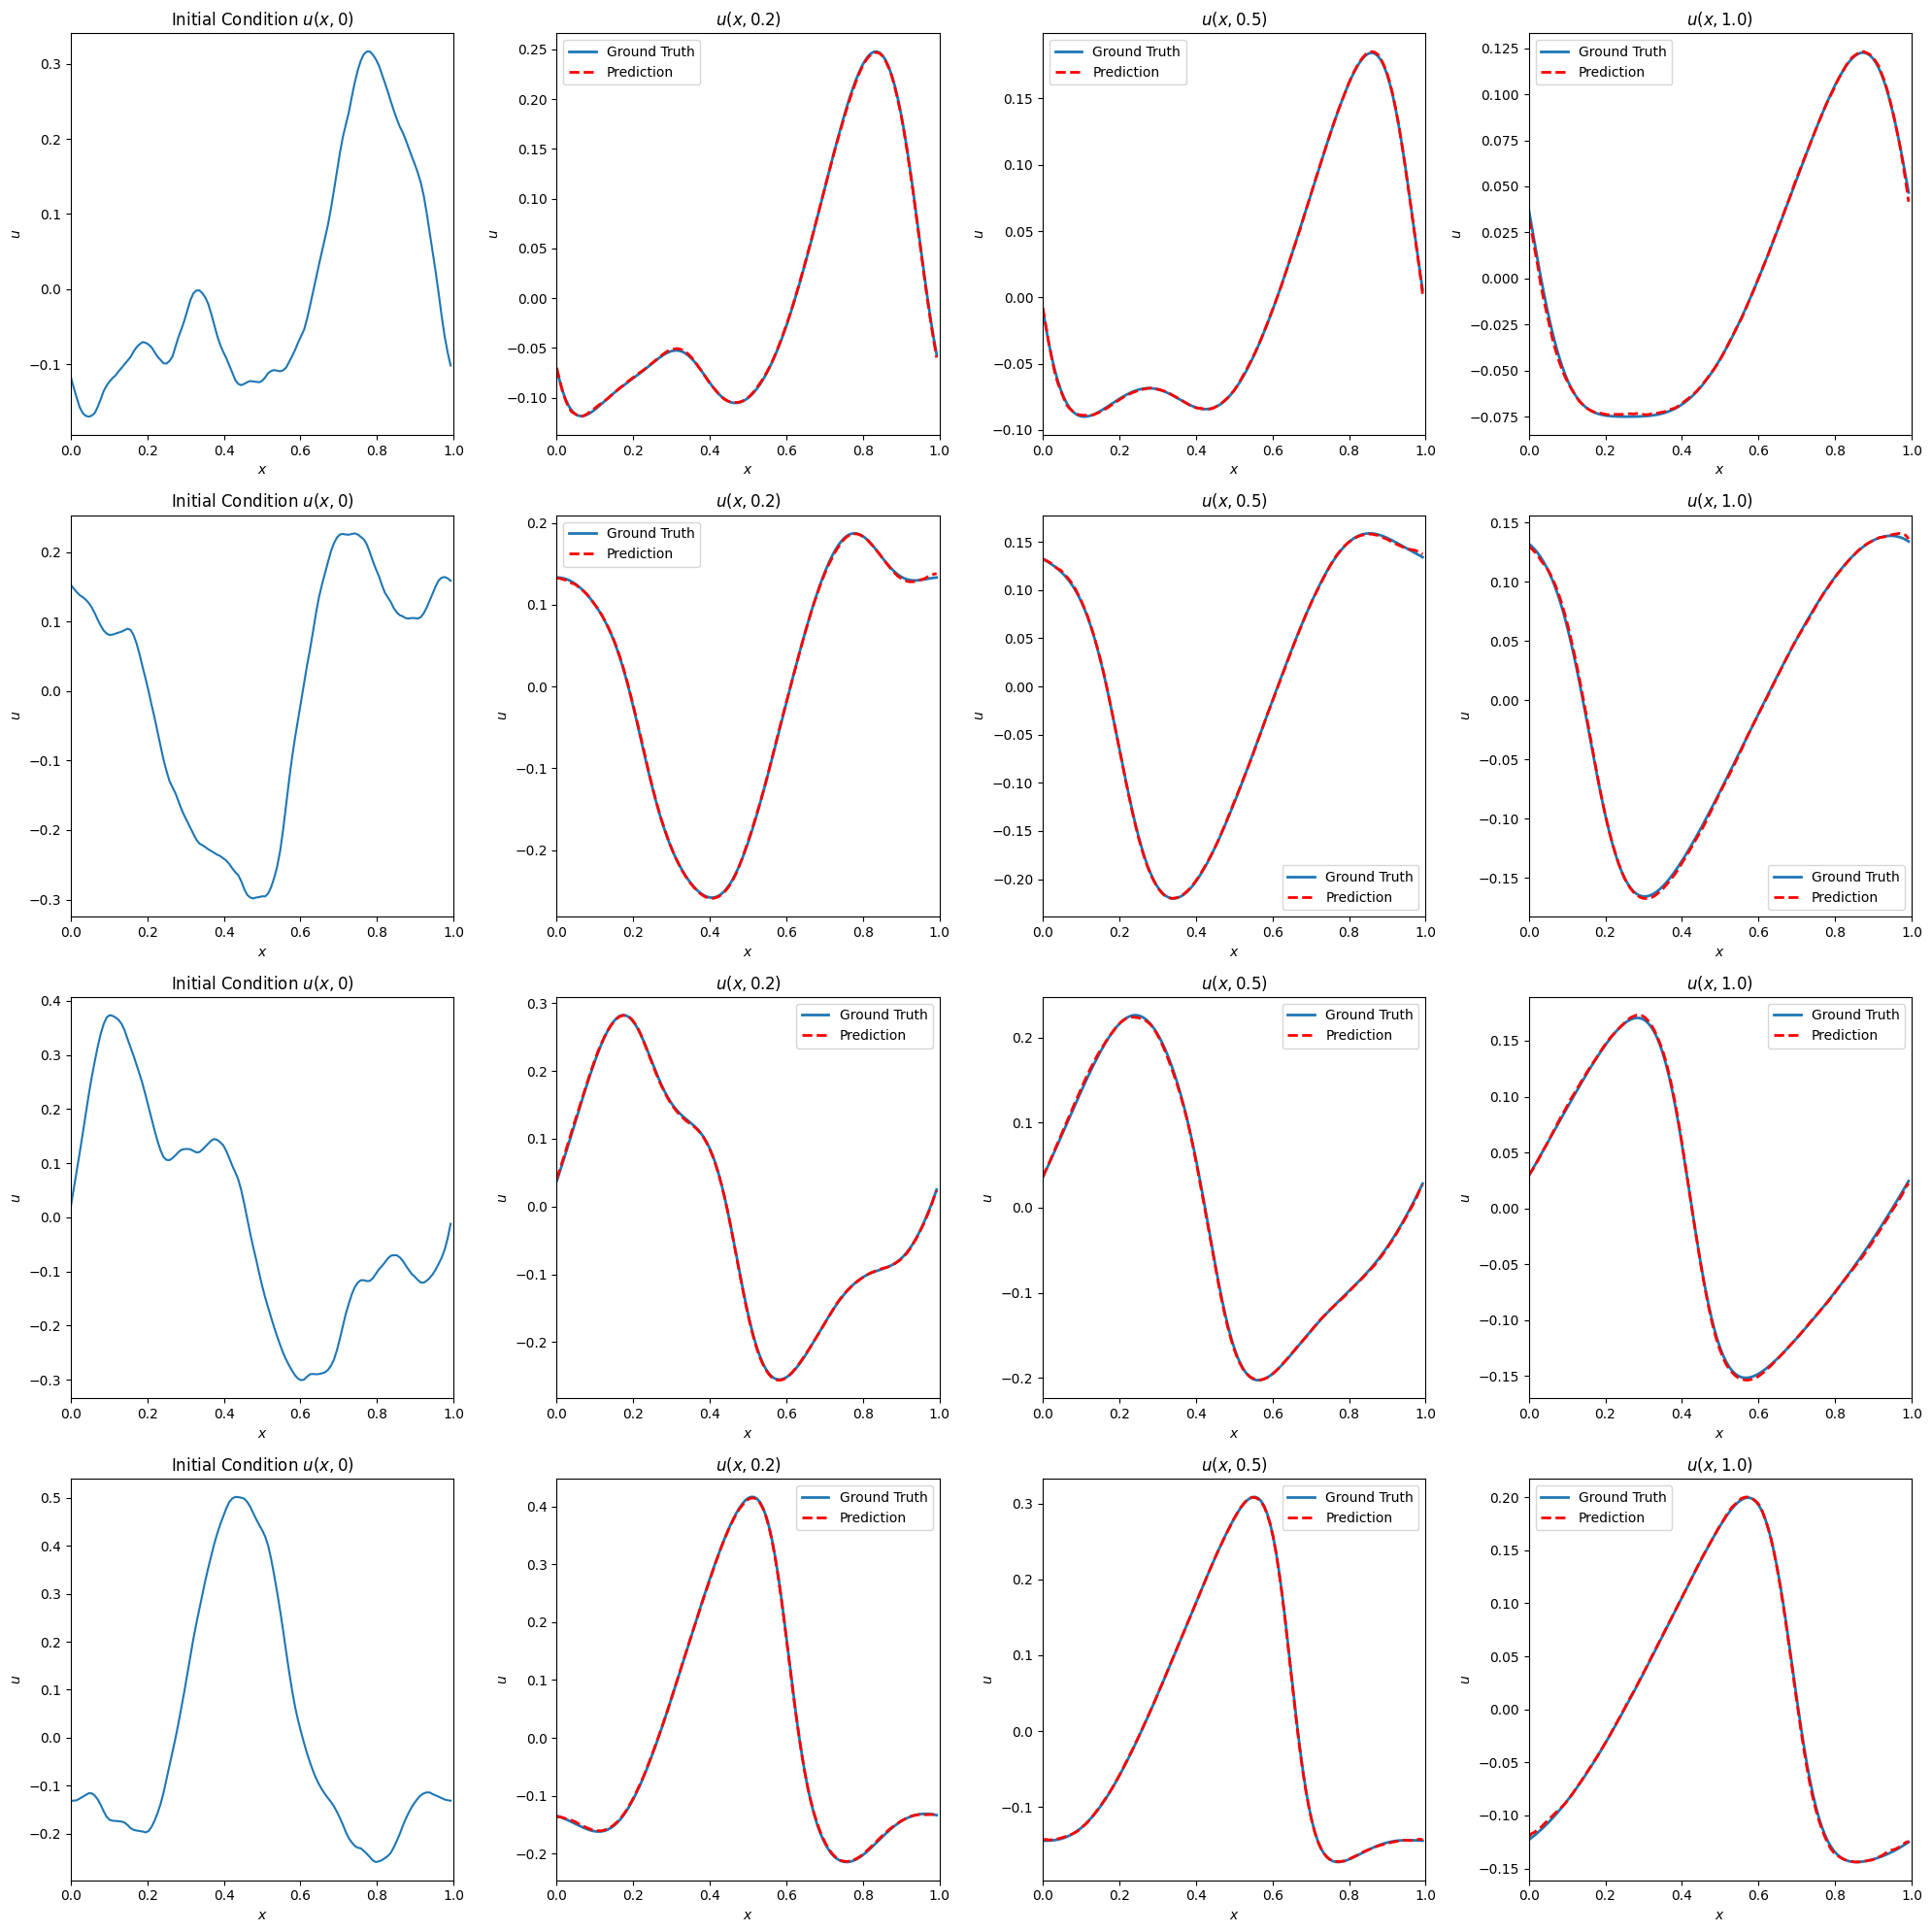

In [29]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i in range(4):
    ax[i, 0].plot(x_range, y[i].squeeze())
    ax[i, 0].set_xlabel('$x$')
    ax[i, 0].set_ylabel('$u$')
    ax[i, 0].set_title('Initial Condition $u(x, 0)$')
    ax[i, 0].set_xlim([0, 1])
    plt.tight_layout()

    ax[i, 1].plot(x_range, x[i, 19], linewidth=2, label='Ground Truth')
    ax[i, 1].plot(x_range, x_pred005_cal[i, 19], linewidth=2, color='red', linestyle='--', label='Prediction')
    ax[i, 1].set_xlabel('$x$')
    ax[i, 1].set_ylabel('$u$')
    ax[i, 1].set_xlim([0, 1])
    ax[i, 1].set_title('$u(x, 0.2)$')
    ax[i, 1].legend()
    plt.tight_layout()

    ax[i, 2].plot(x_range, x[i, 49], linewidth=2, label='Ground Truth')
    ax[i, 2].plot(x_range, x_pred005_cal[i, 49], linewidth=2, color='red', linestyle='--', label='Prediction')
    ax[i, 2].set_xlabel('$x$')
    ax[i, 2].set_ylabel('$u$')
    ax[i, 2].set_xlim([0, 1])
    ax[i, 2].set_title('$u(x, 0.5)$')
    ax[i, 2].legend()
    plt.tight_layout()

    ax[i, 3].plot(x_range, x[i, 99], linewidth=2, label='Ground Truth')
    ax[i, 3].plot(x_range, x_pred005_cal[i, 99], linewidth=2, color='red', linestyle='--', label='Prediction')
    ax[i, 3].set_xlabel('$x$')
    ax[i, 3].set_ylabel('$u$')
    ax[i, 3].set_xlim([0, 1])
    ax[i, 3].set_title('$u(x, 1.0)$')
    ax[i, 3].legend()
    plt.tight_layout()

In [30]:
fig.savefig('../assets/burgers/burgers_prediction.png', dpi=300, bbox_inches='tight')

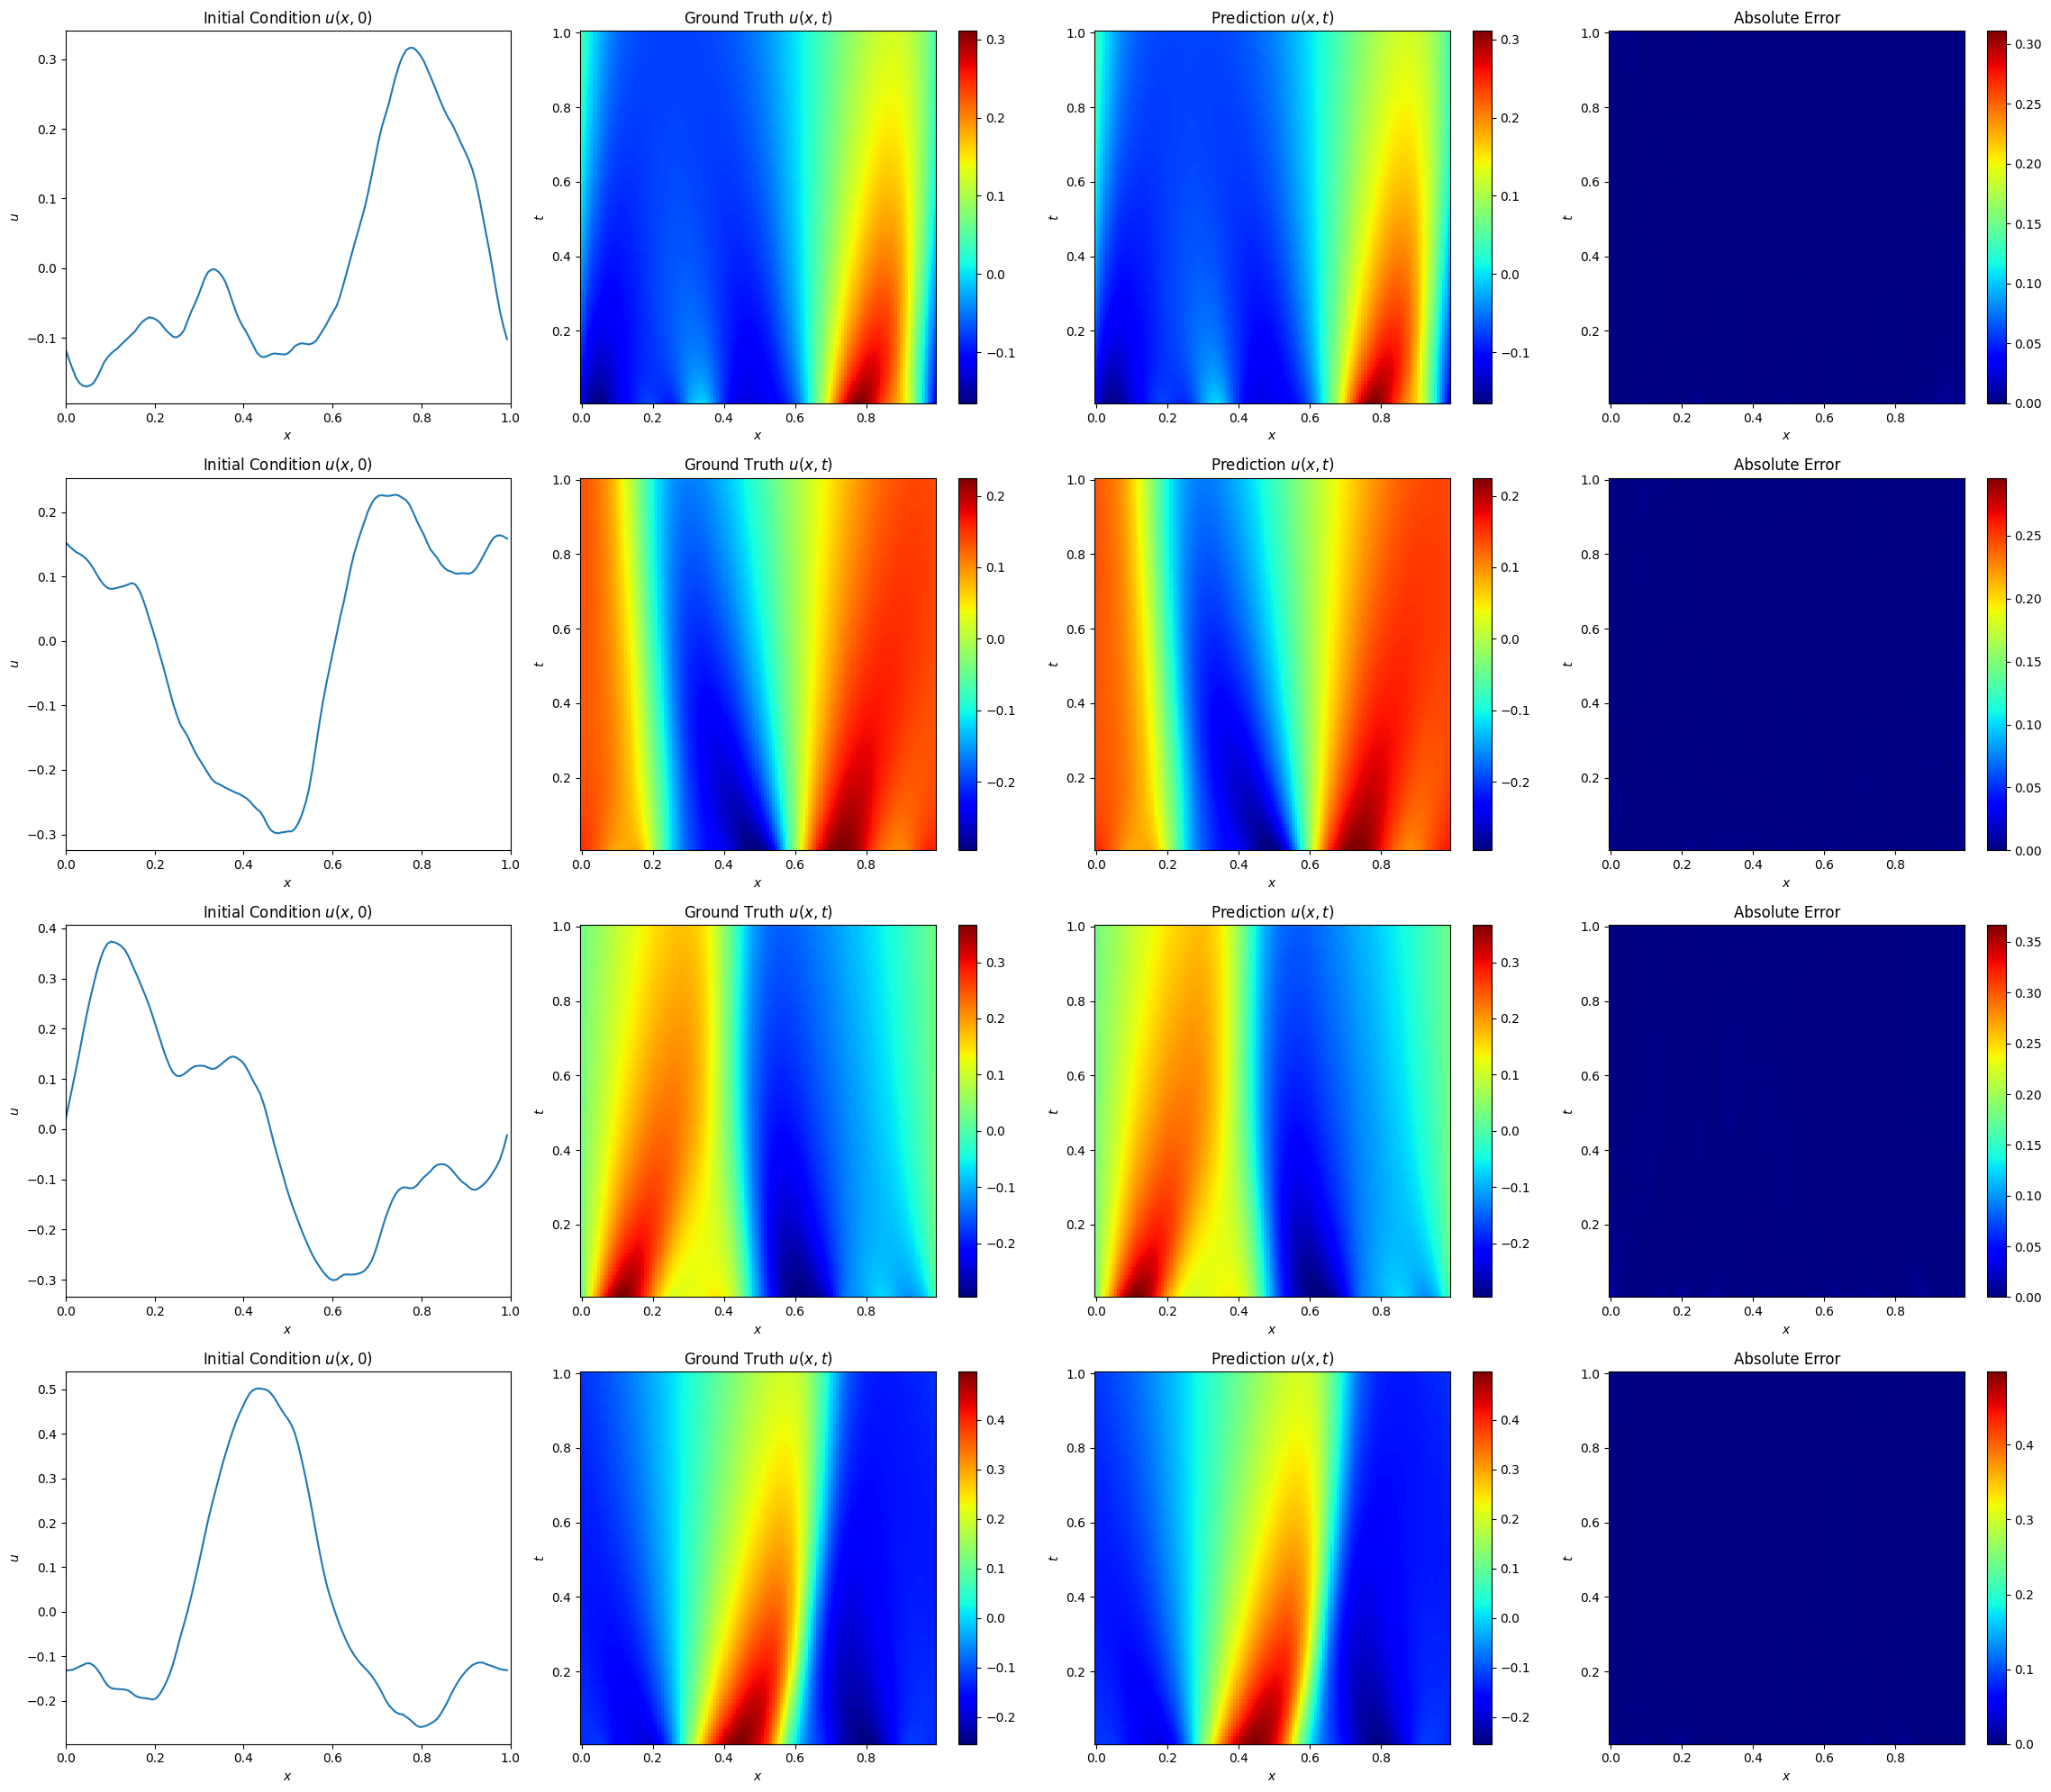

In [25]:
fig, ax = plt.subplots(4, 4, figsize=(23, 20))
relative_error_norm = matplotlib.colors.Normalize(vmin=0, vmax=1.0)
for i in range(4):
    ax[i, 0].plot(x_range, y[i].squeeze())
    ax[i, 0].set_xlabel('$x$')
    ax[i, 0].set_ylabel('$u$')
    ax[i, 0].set_title('Initial Condition $u(x, 0)$')
    ax[i, 0].set_xlim([0, 1])
    plt.tight_layout()

    norm1 = matplotlib.colors.Normalize(vmin=x[i].min(), vmax=x[i].max())
    im1 = ax[i, 1].pcolormesh(X, T, x[i].T, cmap='jet', norm=norm1)
    ax[i, 1].set_xlabel('$x$')
    ax[i, 1].set_ylabel('$t$')
    ax[i, 1].set_title('Ground Truth $u(x, t)$')
    # ax[i, 1].set_axis('square')
    fig.colorbar(im1, ax=ax[i, 1])
    plt.tight_layout()

    im2 = ax[i, 2].pcolormesh(X, T, x_pred005_cal[i].T, cmap='jet', norm=norm1)
    ax[i, 2].set_xlabel('$x$')
    ax[i, 2].set_ylabel('$t$')
    ax[i, 2].set_title('Prediction $u(x, t)$')
    # ax[i, 2].set_axis('square')
    fig.colorbar(im2, ax=ax[i, 2])
    plt.tight_layout()

    norm2 = matplotlib.colors.Normalize(vmin=0, vmax=np.abs(x[i]).max())
    im3 = ax[i, 3].pcolormesh(X, T, np.abs(x[i]-x_pred005_cal[i]).T, cmap='jet', norm=norm2)
    ax[i, 3].set_xlabel('$x$')
    ax[i, 3].set_ylabel('$t$')
    ax[i, 3].set_title('Absolute Error')
    # ax[i, 3].set_axis('square')
    fig.colorbar(im3, ax=ax[i, 3])
    plt.tight_layout()

In [26]:
fig.savefig('../assets/burgers/whole_traj_comparsion.png', bbox_inches='tight', dpi=300)

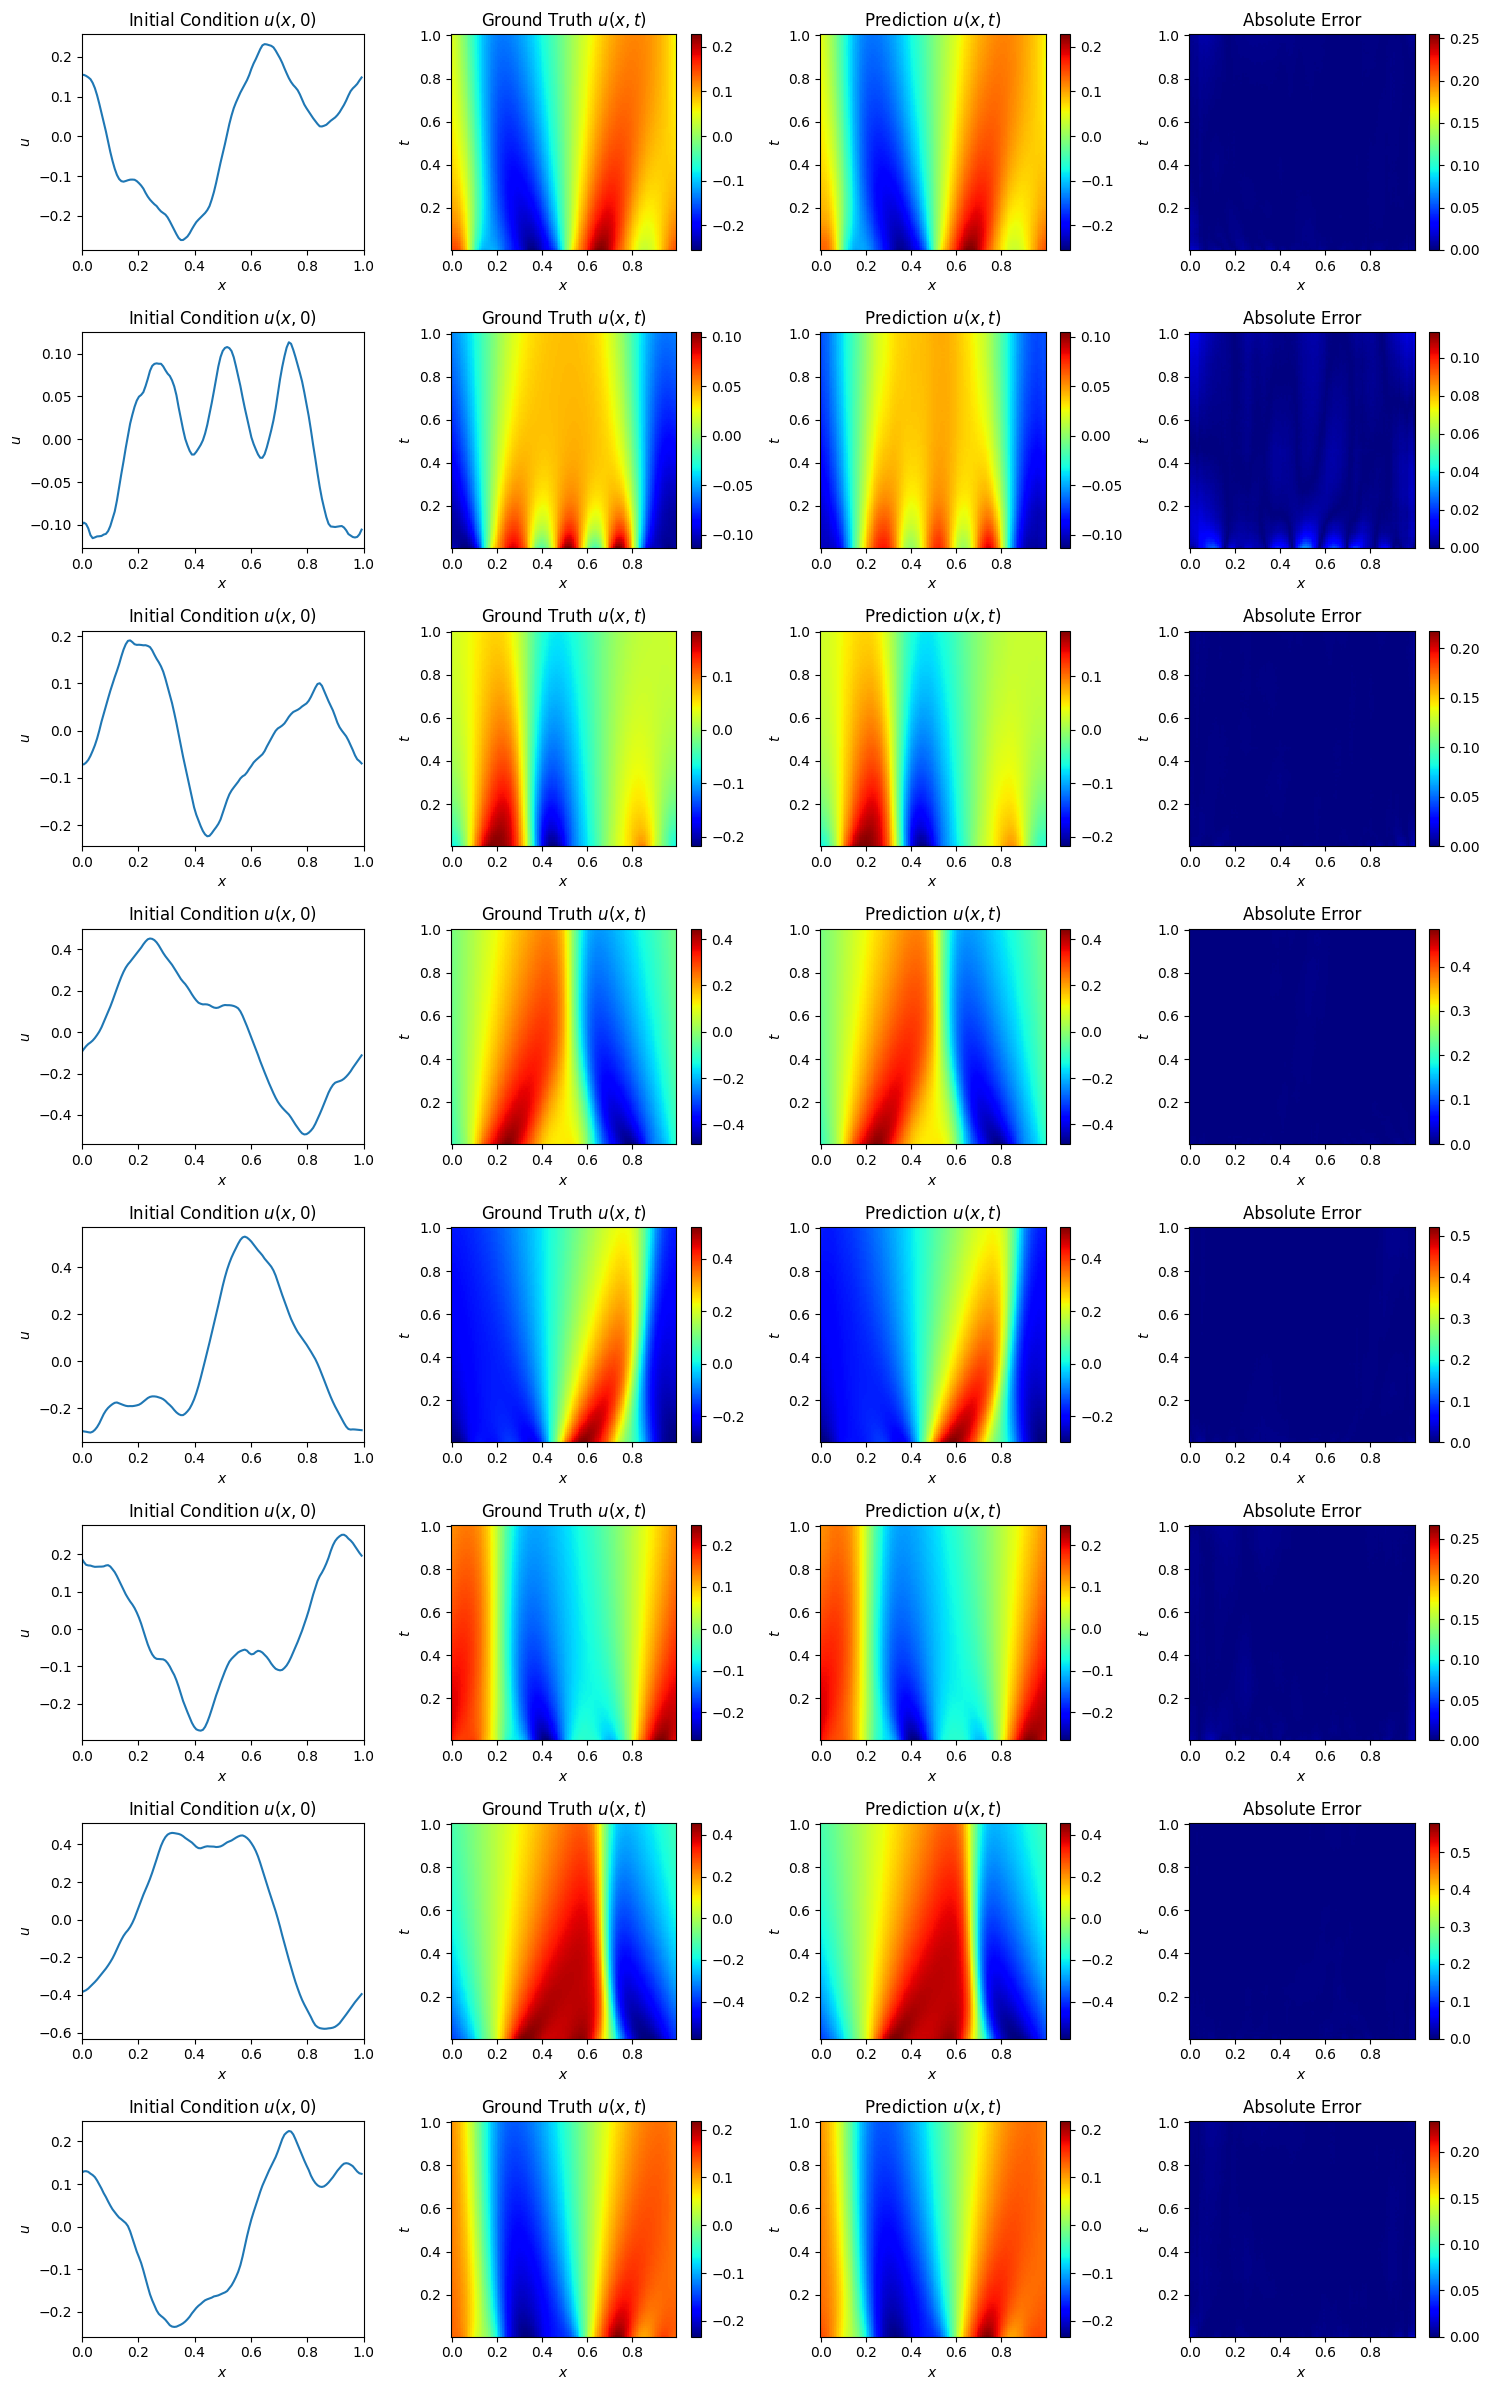

In [31]:
fig, ax = plt.subplots(8, 4, figsize=(15, 24))
relative_error_norm = matplotlib.colors.Normalize(vmin=0, vmax=1.0)
for i in range(8):
    ax[i, 0].plot(x_range, y[i+4].squeeze())
    ax[i, 0].set_xlabel('$x$')
    ax[i, 0].set_ylabel('$u$')
    ax[i, 0].set_title('Initial Condition $u(x, 0)$')
    ax[i, 0].set_xlim([0, 1])
    plt.tight_layout()

    norm1 = matplotlib.colors.Normalize(vmin=x[i+4].min(), vmax=x[i+4].max())
    im1 = ax[i, 1].pcolormesh(X, T, x[i+4].T, cmap='jet', norm=norm1)
    ax[i, 1].set_xlabel('$x$')
    ax[i, 1].set_ylabel('$t$')
    ax[i, 1].set_title('Ground Truth $u(x, t)$')
    # ax[i, 1].set_axis('square')
    fig.colorbar(im1, ax=ax[i, 1])
    plt.tight_layout()

    im2 = ax[i, 2].pcolormesh(X, T, x_pred005_cal[i+4].T, cmap='jet', norm=norm1)
    ax[i, 2].set_xlabel('$x$')
    ax[i, 2].set_ylabel('$t$')
    ax[i, 2].set_title('Prediction $u(x, t)$')
    # ax[i, 2].set_axis('square')
    fig.colorbar(im2, ax=ax[i, 2])
    plt.tight_layout()

    norm2 = matplotlib.colors.Normalize(vmin=0, vmax=np.abs(x[i+4]).max())
    im3 = ax[i, 3].pcolormesh(X, T, np.abs(x[i+4]-x_pred005_cal[i+4]).T, cmap='jet', norm=norm2)
    ax[i, 3].set_xlabel('$x$')
    ax[i, 3].set_ylabel('$t$')
    ax[i, 3].set_title('Absolute Error')
    # ax[i, 3].set_axis('square')
    fig.colorbar(im3, ax=ax[i, 3])
    plt.tight_layout()

In [32]:
fig.savefig('../assets/burgers/whole_traj_comparsion_2.png', bbox_inches='tight', dpi=300)

### Mean and Variance of Prediction

In [6]:
x = ds[71:72]['x']
y = ds[71:72]['y']

In [7]:
y_repeat = y.repeat(16, 1, 1)

In [8]:
x_pred005_cal_repeat = make_prediction(diffusion_model, y_repeat, 0.05, True)

DDPM sampling: 100%|██████████| 800/800 [02:14<00:00,  5.93it/s]


In [10]:
x_pred005_cal_repeat_mean = np.mean(x_pred005_cal_repeat, axis=0)
x_pred005_cal_repeat_std = np.std(x_pred005_cal_repeat, axis=0)

In [11]:
x = x.squeeze().numpy()

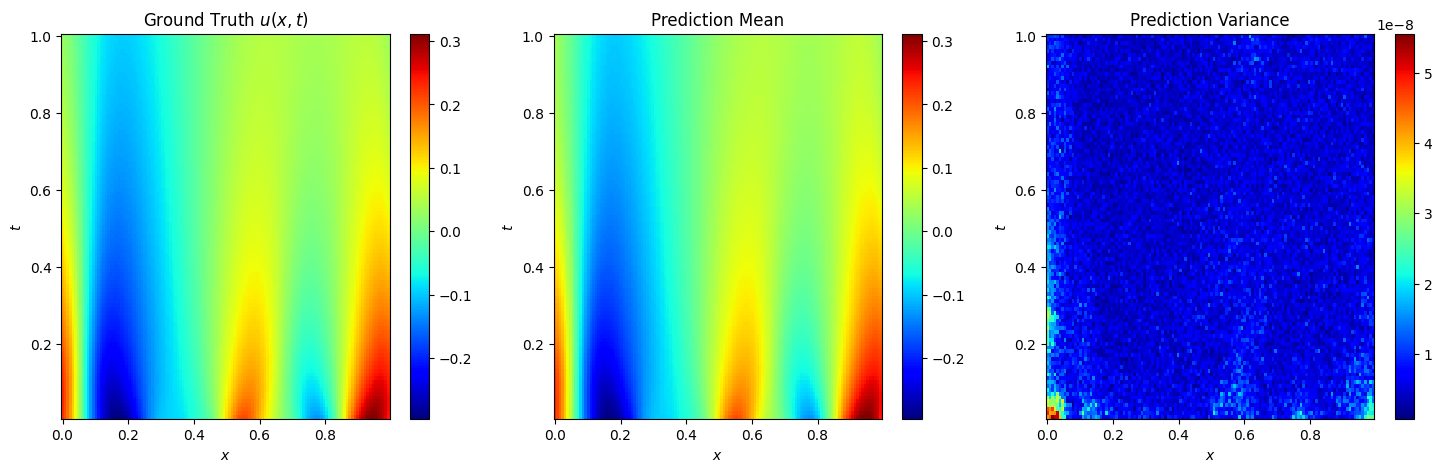

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
norm = matplotlib.colors.Normalize(vmin=x.min(), vmax=x.max())
im1 = ax[0].pcolormesh(X, T, x.T, cmap='jet', norm=norm)
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$t$')
ax[0].set_title('Ground Truth $u(x, t)$')
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].pcolormesh(X, T, x_pred005_cal_repeat_mean.T, cmap='jet', norm=norm)
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$t$')
ax[1].set_title('Prediction Mean')
fig.colorbar(im2, ax=ax[1])

im3 = ax[2].pcolormesh(X, T, (x_pred005_cal_repeat_std**2).T, cmap='jet')
ax[2].set_xlabel('$x$')
ax[2].set_ylabel('$t$')
ax[2].set_title('Prediction Variance')
fig.colorbar(im3, ax=ax[2])

In [18]:
fig.savefig('../assets/burgers/uncertainty.png', bbox_inches='tight', dpi=300)

### Different Parameters Settings Comparsion

In [6]:
x = ds[170:186]['x']
y = ds[170:186]['y']

In [9]:
x_pred000 = make_prediction(diffusion_model, y, 0.0, False)
x_pred005 = make_prediction(diffusion_model, y, 0.05, False)
x_pred010 = make_prediction(diffusion_model, y, 0.1, False)
x_pred020 = make_prediction(diffusion_model, y, 0.2, False)
x_pred000_cal = x_pred000
x_pred005_cal = make_prediction(diffusion_model, y, 0.05, True)
x_pred010_cal = make_prediction(diffusion_model, y, 0.1, True)
x_pred020_cal = make_prediction(diffusion_model, y, 0.2, True)

DDPM sampling: 100%|██████████| 800/800 [02:13<00:00,  5.99it/s]


In [10]:
x = x.numpy().squeeze()
y = y.numpy().squeeze()

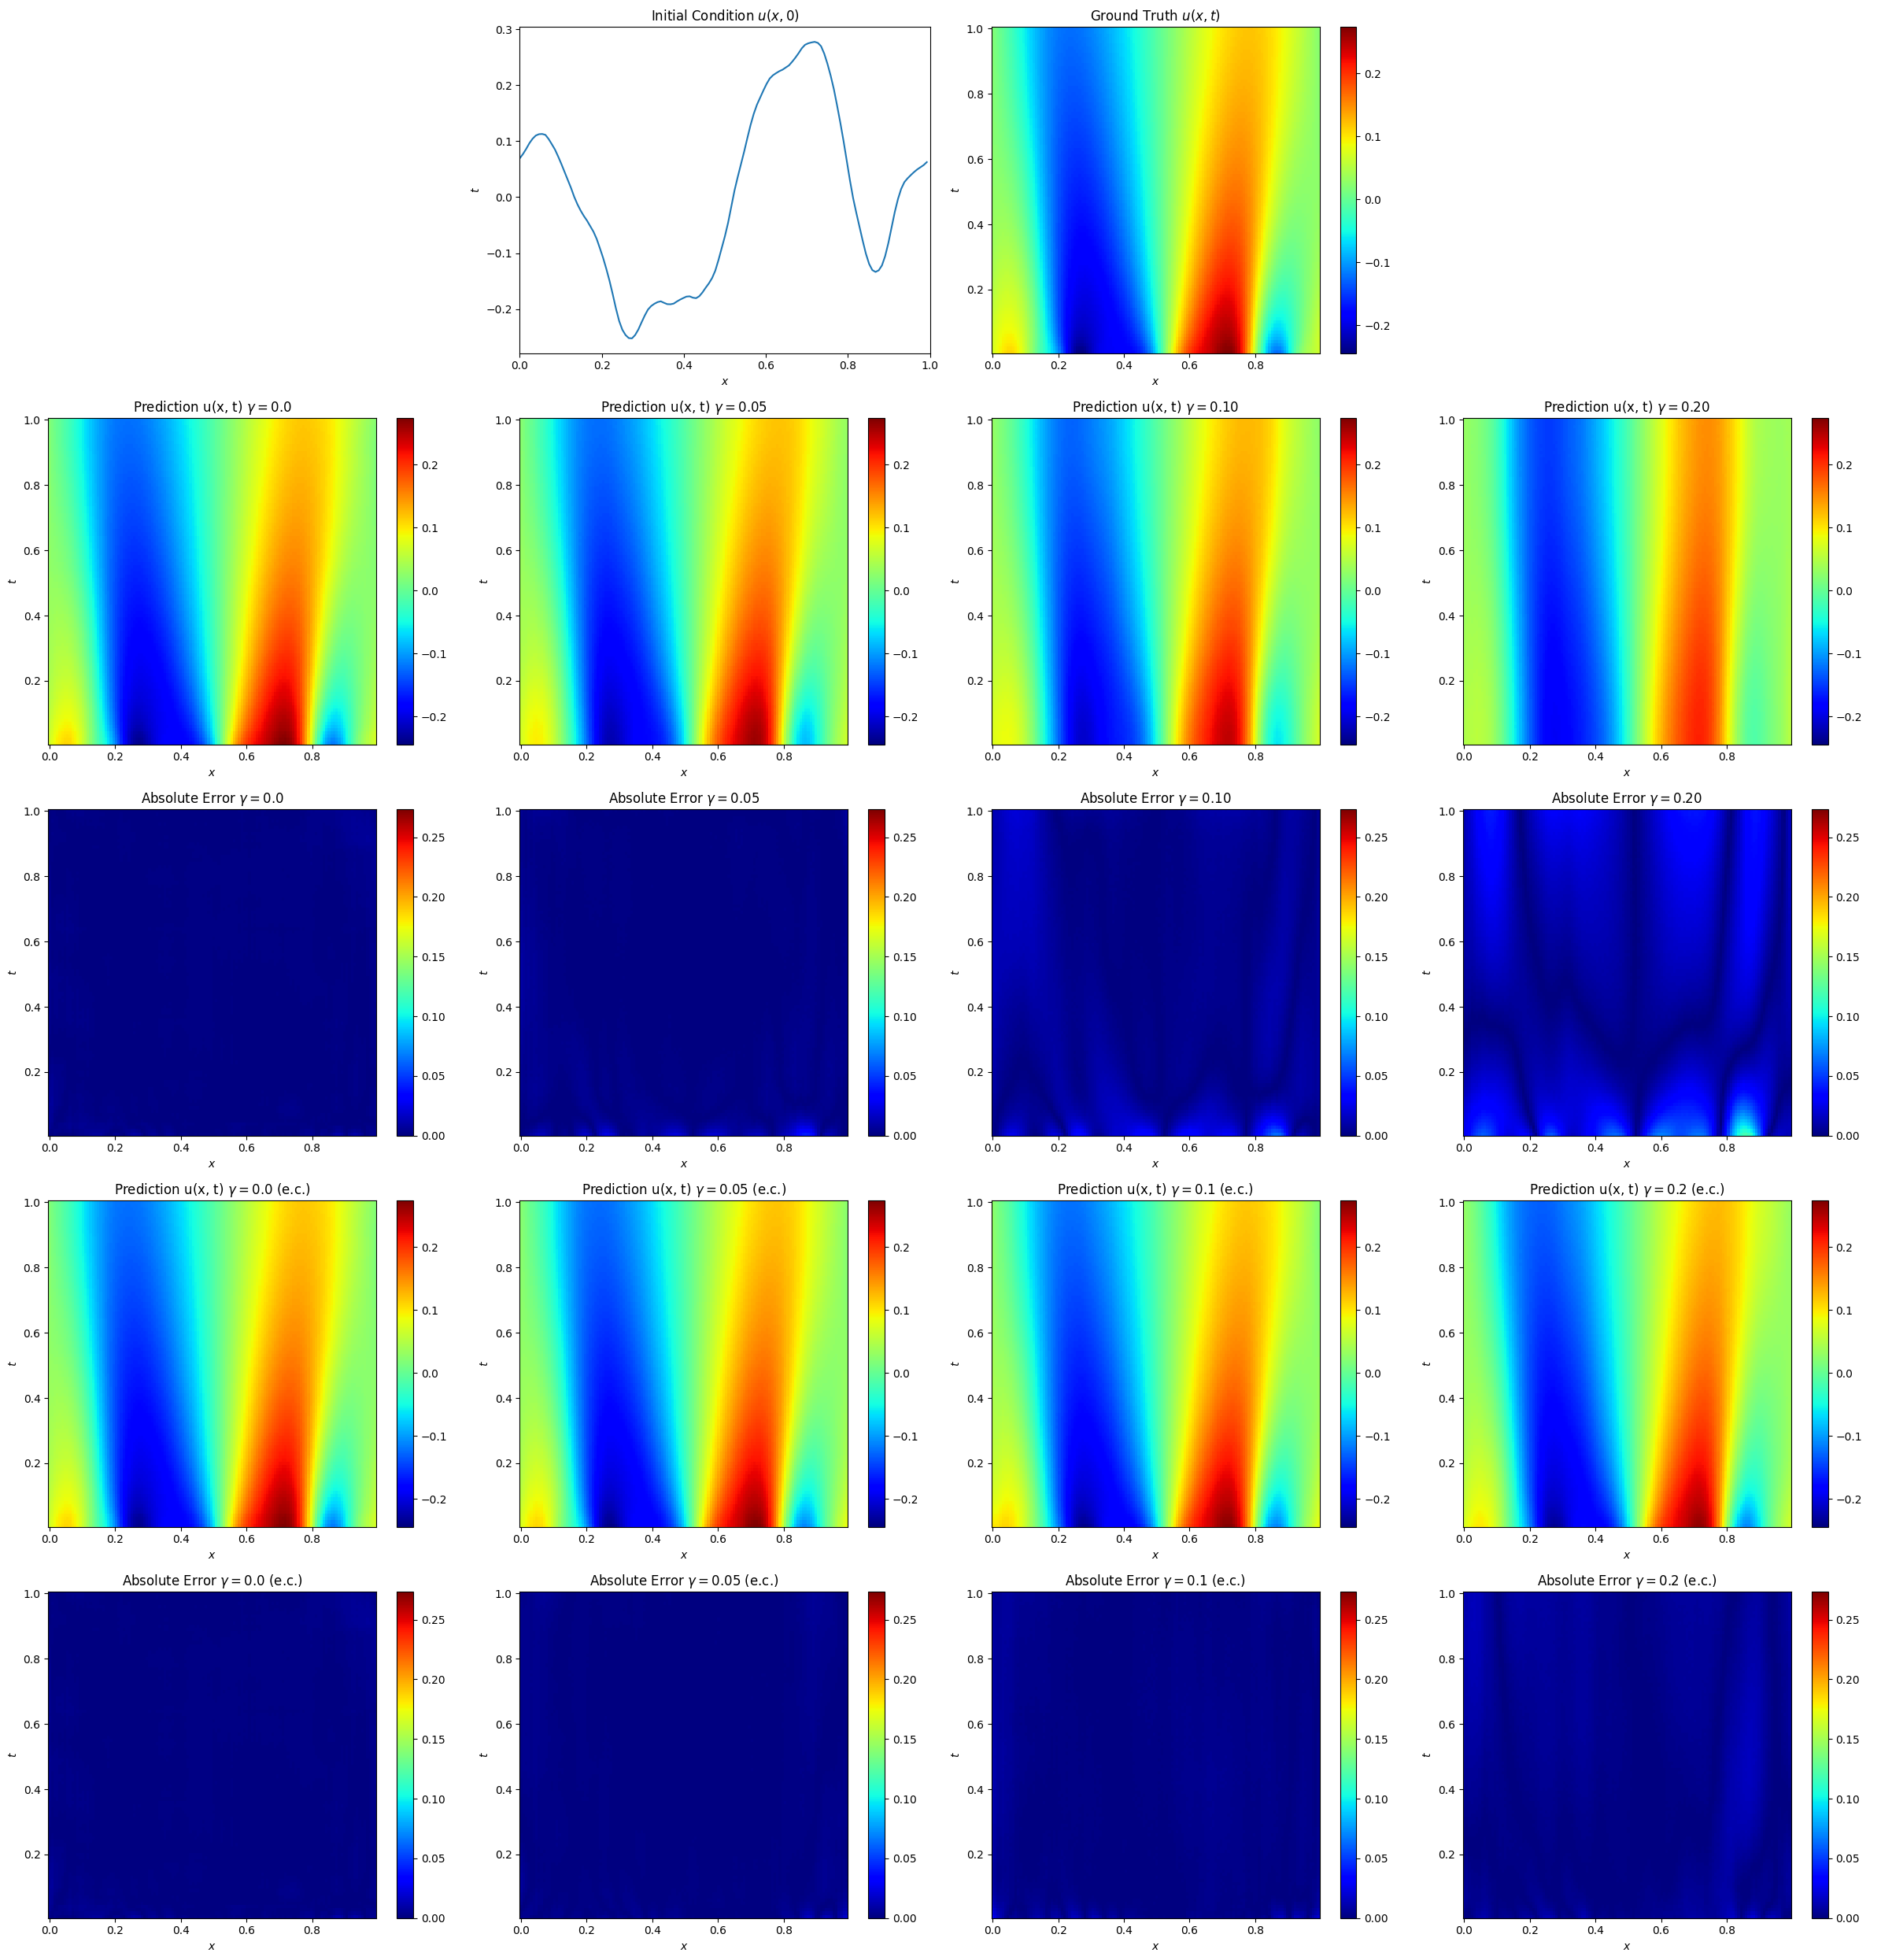

In [18]:
n = 5
norm1 = matplotlib.colors.Normalize(vmin=x[n].min(), vmax=x[n].max())
norm2 = matplotlib.colors.Normalize(vmin=0, vmax=np.abs(x[n]).max())
fig, ax = plt.subplots(5, 4, figsize=(24, 25))
ax[0, 0].set_axis_off()
ax[0, 3].set_axis_off()

im1 = ax[0, 1].plot(x_range, y[n].squeeze())
ax[0, 1].set_xlabel('$x$')
ax[0, 1].set_ylabel('$t$')
ax[0, 1].set_title('Initial Condition $u(x, 0)$')
ax[0, 1].set_xlim([0, 1])
plt.tight_layout()

im2 = ax[0, 2].pcolormesh(X, T, x[n].T, cmap='jet', norm=norm1)
ax[0, 2].set_xlabel('$x$')
ax[0, 2].set_ylabel('$t$')
ax[0, 2].set_title('Ground Truth $u(x, t)$')
fig.colorbar(im2, ax=ax[0, 2])
plt.tight_layout()

im3 = ax[1, 0].pcolormesh(X, T, x_pred000[n].T, cmap='jet', norm=norm1)
ax[1, 0].set_xlabel('$x$')
ax[1, 0].set_ylabel('$t$')
ax[1, 0].set_title(r'Prediction u(x, t) $\gamma=0.0$')
fig.colorbar(im3, ax=ax[1, 0])
plt.tight_layout()

im4 = ax[1, 1].pcolormesh(X, T, x_pred005[n].T, cmap='jet', norm=norm1)
ax[1, 1].set_xlabel('$x$')
ax[1, 1].set_ylabel('$t$')
ax[1, 1].set_title(r'Prediction u(x, t) $\gamma=0.05$')
fig.colorbar(im4, ax=ax[1, 1])
plt.tight_layout()

im5 = ax[1, 2].pcolormesh(X, T, x_pred010[n].T, cmap='jet', norm=norm1)
ax[1, 2].set_xlabel('$x$')
ax[1, 2].set_ylabel('$t$')
ax[1, 2].set_title(r'Prediction u(x, t) $\gamma=0.10$')
fig.colorbar(im5, ax=ax[1, 2])
plt.tight_layout()

im6 = ax[1, 3].pcolormesh(X, T, x_pred020[n].T, cmap='jet', norm=norm1)
ax[1, 3].set_xlabel('$x$')
ax[1, 3].set_ylabel('$t$')
ax[1, 3].set_title(r'Prediction u(x, t) $\gamma=0.20$')
fig.colorbar(im6, ax=ax[1, 3])
plt.tight_layout()

im7 = ax[2, 0].pcolormesh(X, T, np.abs(x_pred000[n]-x[n]).T, cmap='jet', norm=norm2)
ax[2, 0].set_xlabel('$x$')
ax[2, 0].set_ylabel('$t$')
ax[2, 0].set_title(r'Absolute Error $\gamma=0.0$')
fig.colorbar(im7, ax=ax[2, 0])
plt.tight_layout()

im8 = ax[2, 1].pcolormesh(X, T, np.abs(x_pred005[n]-x[n]).T, cmap='jet', norm=norm2)
ax[2, 1].set_xlabel('$x$')
ax[2, 1].set_ylabel('$t$')
ax[2, 1].set_title(r'Absolute Error $\gamma=0.05$')
fig.colorbar(im8, ax=ax[2, 1])
plt.tight_layout()

im9 = ax[2, 2].pcolormesh(X, T, np.abs(x_pred010[n]-x[n]).T, cmap='jet', norm=norm2)
ax[2, 2].set_xlabel('$x$')
ax[2, 2].set_ylabel('$t$')
ax[2, 2].set_title(r'Absolute Error $\gamma=0.10$')
fig.colorbar(im9, ax=ax[2, 2])
plt.tight_layout()

im10 = ax[2, 3].pcolormesh(X, T, np.abs(x_pred020[n]-x[n]).T, cmap='jet', norm=norm2)
ax[2, 3].set_xlabel('$x$')
ax[2, 3].set_ylabel('$t$')
ax[2, 3].set_title(r'Absolute Error $\gamma=0.20$')
fig.colorbar(im10, ax=ax[2, 3])
plt.tight_layout()

im11 = ax[3, 0].pcolormesh(X, T, x_pred000[n].T, cmap='jet', norm=norm1)
ax[3, 0].set_xlabel('$x$')
ax[3, 0].set_ylabel('$t$')
ax[3, 0].set_title(r'Prediction u(x, t) $\gamma=0.0$ (e.c.)')
fig.colorbar(im11, ax=ax[3, 0])
plt.tight_layout()

im12 = ax[3, 1].pcolormesh(X, T, x_pred005_cal[n].T, cmap='jet', norm=norm1)
ax[3, 1].set_xlabel('$x$')
ax[3, 1].set_ylabel('$t$')
ax[3, 1].set_title(r'Prediction u(x, t) $\gamma=0.05$ (e.c.)')
fig.colorbar(im12, ax=ax[3, 1])
plt.tight_layout()

im13 = ax[3, 2].pcolormesh(X, T, x_pred010_cal[n].T, cmap='jet', norm=norm1)
ax[3, 2].set_xlabel('$x$')
ax[3, 2].set_ylabel('$t$')
ax[3, 2].set_title(r'Prediction u(x, t) $\gamma=0.1$ (e.c.)')
fig.colorbar(im13, ax=ax[3, 2])
plt.tight_layout()

im14 = ax[3, 3].pcolormesh(X, T, x_pred020_cal[n].T, cmap='jet', norm=norm1)
ax[3, 3].set_xlabel('$x$')
ax[3, 3].set_ylabel('$t$')
ax[3, 3].set_title(r'Prediction u(x, t) $\gamma=0.2$ (e.c.)')
fig.colorbar(im14, ax=ax[3, 3])
plt.tight_layout()

im15 = ax[4, 0].pcolormesh(X, T, np.abs(x_pred000[n]-x[n]).T, cmap='jet', norm=norm2)
ax[4, 0].set_xlabel('$x$')
ax[4, 0].set_ylabel('$t$')
ax[4, 0].set_title(r'Absolute Error $\gamma=0.0$ (e.c.)')
fig.colorbar(im10, ax=ax[4, 0])
plt.tight_layout()

im16 = ax[4, 1].pcolormesh(X, T, np.abs(x_pred005_cal[n]-x[n]).T, cmap='jet', norm=norm2)
ax[4, 1].set_xlabel('$x$')
ax[4, 1].set_ylabel('$t$')
ax[4, 1].set_title(r'Absolute Error $\gamma=0.05$ (e.c.)')
fig.colorbar(im16, ax=ax[4, 1])
plt.tight_layout()

im17 = ax[4, 2].pcolormesh(X, T, np.abs(x_pred010_cal[n]-x[n]).T, cmap='jet', norm=norm2)
ax[4, 2].set_xlabel('$x$')
ax[4, 2].set_ylabel('$t$')
ax[4, 2].set_title(r'Absolute Error $\gamma=0.1$ (e.c.)')
fig.colorbar(im17, ax=ax[4, 2])
plt.tight_layout()

im18 = ax[4, 3].pcolormesh(X, T, np.abs(x_pred020_cal[n]-x[n]).T, cmap='jet', norm=norm2)
ax[4, 3].set_xlabel('$x$')
ax[4, 3].set_ylabel('$t$')
ax[4, 3].set_title(r'Absolute Error $\gamma=0.2$ (e.c.)')
fig.colorbar(im18, ax=ax[4, 3])
plt.tight_layout()

In [19]:
fig.savefig('../assets/burgers/parameters_comparsion.png', bbox_inches='tight', dpi=300)

In [20]:
def cal_nRMSE(x, x_pred):
    norm1 = np.linalg.norm(x-x_pred, axis=(1, 2))
    norm2 = np.linalg.norm(x, axis=(1, 2))
    mean = np.sqrt(norm1**2 / norm2**2).mean(axis=0)
    std = np.sqrt(norm1**2 / norm2**2).std(axis=0)
    return {'mean': mean, 'std': std}

In [21]:
nRMSE000 = cal_nRMSE(x, x_pred000)
nRMSE005 = cal_nRMSE(x, x_pred005)
nRMSE010 = cal_nRMSE(x, x_pred010)
nRMSE020 = cal_nRMSE(x, x_pred020)
nRMSE000_cal = nRMSE000
nRMSE005_cal = cal_nRMSE(x, x_pred005_cal)
nRMSE010_cal = cal_nRMSE(x, x_pred010_cal)
nRMSE020_cal = cal_nRMSE(x, x_pred020_cal)

In [22]:
print(f"nRMSE for 0.00 physics loss: {nRMSE000['mean']:.4f} ± {nRMSE000['std']:.4f}")
print(f"nRMSE for 0.05 physics loss: {nRMSE005['mean']:.4f} ± {nRMSE005['std']:.4f}")
print(f"nRMSE for 0.10 physics loss: {nRMSE010['mean']:.4f} ± {nRMSE010['std']:.4f}")
print(f"nRMSE for 0.20 physics loss: {nRMSE020['mean']:.4f} ± {nRMSE020['std']:.4f}")
print(f"nRMSE for 0.00 physics loss (e.c.): {nRMSE000_cal['mean']:.4f} ± {nRMSE000_cal['std']:.4f}")
print(f"nRMSE for 0.05 physics loss (e.c.): {nRMSE005_cal['mean']:.4f} ± {nRMSE005_cal['std']:.4f}")
print(f"nRMSE for 0.10 physics loss (e.c.): {nRMSE010_cal['mean']:.4f} ± {nRMSE010_cal['std']:.4f}")
print(f"nRMSE for 0.20 physics loss (e.c.): {nRMSE020_cal['mean']:.4f} ± {nRMSE020_cal['std']:.4f}")

nRMSE for 0.00 physics loss: 0.0084 ± 0.0034
nRMSE for 0.05 physics loss: 0.0212 ± 0.0058
nRMSE for 0.10 physics loss: 0.0574 ± 0.0133
nRMSE for 0.20 physics loss: 0.1290 ± 0.0291
nRMSE for 0.00 physics loss (e.c.): 0.0084 ± 0.0034
nRMSE for 0.05 physics loss (e.c.): 0.0095 ± 0.0039
nRMSE for 0.10 physics loss (e.c.): 0.0191 ± 0.0071
nRMSE for 0.20 physics loss (e.c.): 0.0247 ± 0.0118


In [23]:
def cal_bRMSE(x, x_pred):
    x_boundary = x.copy()
    x_boundary[:, 1:-1, 1:-1] = 0
    x_pred_boundary = x_pred.copy()
    x_pred_boundary[:, 1:-1, 1:-1] = 0
    norm1 = np.linalg.norm(x_boundary-x_pred_boundary, axis=(1, 2))
    norm2 = np.linalg.norm(x_boundary, axis=(1, 2))
    mean = np.sqrt(norm1**2 / norm2**2).mean(axis=0)
    std = np.sqrt(norm1**2 / norm2**2).std(axis=0)
    return {'mean': mean, 'std': std}

In [24]:
bRMSE000 = cal_bRMSE(x, x_pred000)
bRMSE005 = cal_bRMSE(x, x_pred005)
bRMSE010 = cal_bRMSE(x, x_pred010)
bRMSE020 = cal_bRMSE(x, x_pred020)
bRMSE000_cal = bRMSE000
bRMSE005_cal = cal_bRMSE(x, x_pred005_cal)
bRMSE010_cal = cal_bRMSE(x, x_pred010_cal)
bRMSE020_cal = cal_bRMSE(x, x_pred020_cal)

In [25]:
print(f"bRMSE for 0.00 physics loss: {bRMSE000['mean']:.4f} ± {bRMSE000['std']:.4f}")
print(f"bRMSE for 0.05 physics loss: {bRMSE005['mean']:.4f} ± {bRMSE005['std']:.4f}")
print(f"bRMSE for 0.10 physics loss: {bRMSE010['mean']:.4f} ± {bRMSE010['std']:.4f}")
print(f"bRMSE for 0.20 physics loss: {bRMSE020['mean']:.4f} ± {bRMSE020['std']:.4f}")
print(f"bRMSE for 0.00 physics loss (e.c.): {bRMSE000_cal['mean']:.4f} ± {bRMSE000_cal['std']:.4f}")
print(f"bRMSE for 0.05 physics loss (e.c.): {bRMSE005_cal['mean']:.4f} ± {bRMSE005_cal['std']:.4f}")
print(f"bRMSE for 0.10 physics loss (e.c.): {bRMSE010_cal['mean']:.4f} ± {bRMSE010_cal['std']:.4f}")
print(f"bRMSE for 0.20 physics loss (e.c.): {bRMSE020_cal['mean']:.4f} ± {bRMSE020_cal['std']:.4f}")

bRMSE for 0.00 physics loss: 0.0195 ± 0.0093
bRMSE for 0.05 physics loss: 0.0617 ± 0.0171
bRMSE for 0.10 physics loss: 0.1223 ± 0.0287
bRMSE for 0.20 physics loss: 0.2293 ± 0.0528
bRMSE for 0.00 physics loss (e.c.): 0.0195 ± 0.0093
bRMSE for 0.05 physics loss (e.c.): 0.0203 ± 0.0100
bRMSE for 0.10 physics loss (e.c.): 0.0394 ± 0.0183
bRMSE for 0.20 physics loss (e.c.): 0.0400 ± 0.0193


In [11]:
def cal_temporal_abs_error(x, x_pred):
    norm1 = np.linalg.norm(x-x_pred, axis=2)
    norm2 = np.linalg.norm(x, axis=2)
    mean = np.sqrt(norm1**2 / norm2**2).mean(axis=0)
    std = np.sqrt(norm1**2 / norm2**2).std(axis=0)
    return {'mean': mean, 'std': std}

In [12]:
t_nRMSE000 = cal_temporal_abs_error(x, x_pred000)
t_nRMSE005 = cal_temporal_abs_error(x, x_pred005)
t_nRMSE010 = cal_temporal_abs_error(x, x_pred010)
t_nRMSE020 = cal_temporal_abs_error(x, x_pred020)
t_nRMSE000_cal = t_nRMSE000
t_nRMSE005_cal = cal_temporal_abs_error(x, x_pred005_cal)
t_nRMSE010_cal = cal_temporal_abs_error(x, x_pred010_cal)
t_nRMSE020_cal = cal_temporal_abs_error(x, x_pred020_cal)

(0.0, 1.0)

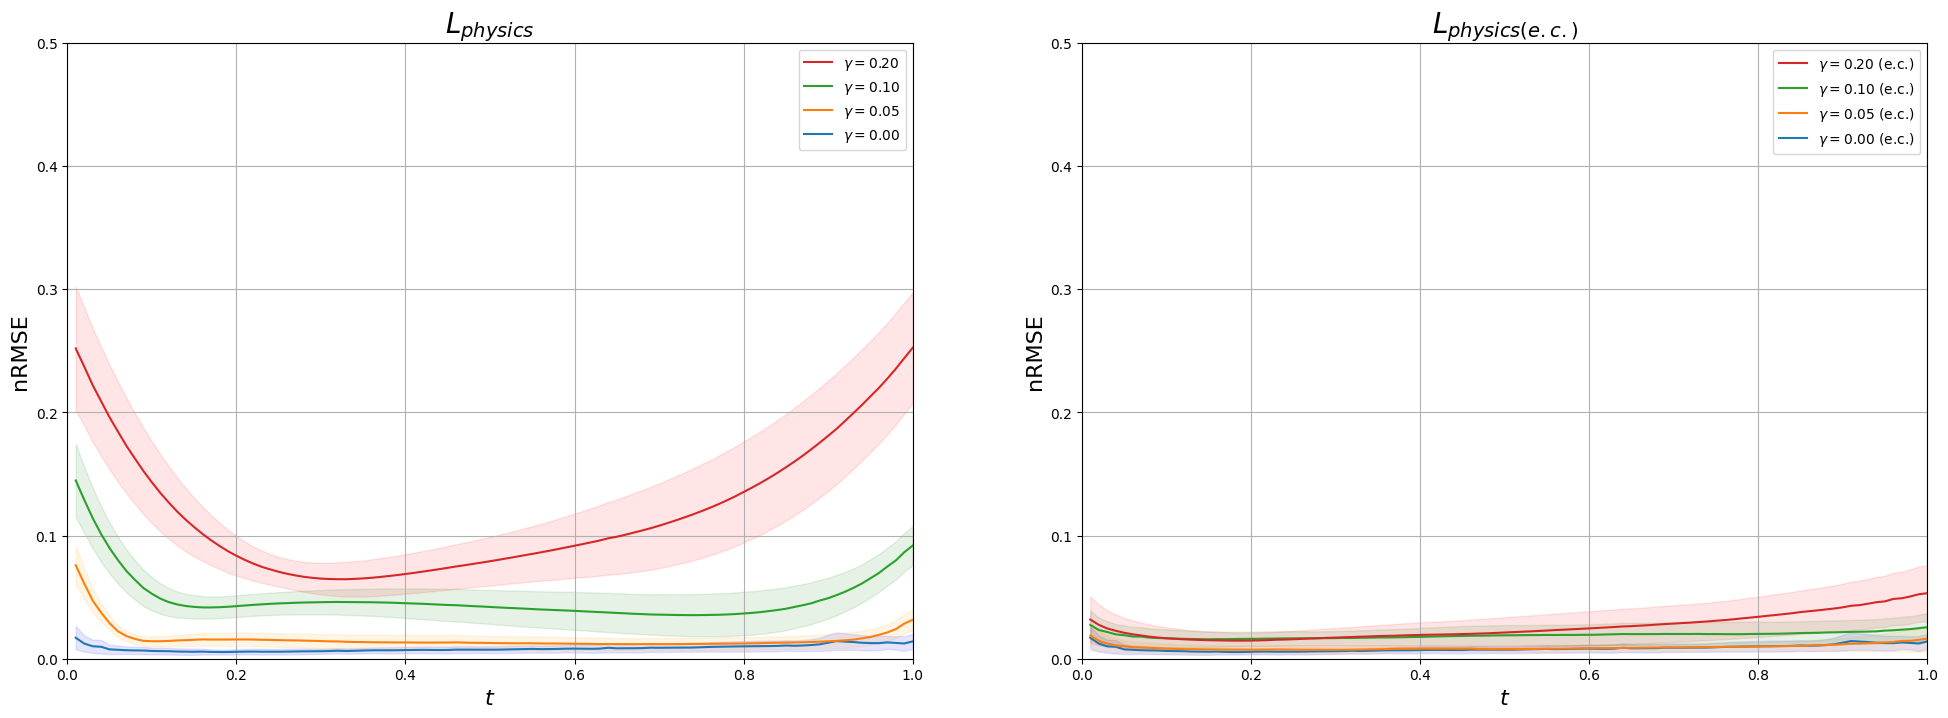

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[0].plot(t_range, t_nRMSE000['mean'], label=r'$\gamma=0.00$')
ax[0].fill_between(t_range, t_nRMSE000['mean']-t_nRMSE000['std'], t_nRMSE000['mean']+t_nRMSE000['std'], color='blue', alpha=0.1)
ax[0].plot(t_range, t_nRMSE005['mean'], label=r'$\gamma=0.05$')
ax[0].fill_between(t_range, t_nRMSE005['mean']-t_nRMSE005['std'], t_nRMSE005['mean']+t_nRMSE005['std'], color='orange', alpha=0.1)
ax[0].plot(t_range, t_nRMSE010['mean'], label=r'$\gamma=0.10$')
ax[0].fill_between(t_range, t_nRMSE010['mean']-t_nRMSE010['std'], t_nRMSE010['mean']+t_nRMSE010['std'], color='green', alpha=0.1)
ax[0].plot(t_range, t_nRMSE020['mean'], label=r'$\gamma=0.20$')
ax[0].fill_between(t_range, t_nRMSE020['mean']-t_nRMSE020['std'], t_nRMSE020['mean']+t_nRMSE020['std'], color='red', alpha=0.1)
ax[0].set_xlabel('$t$', fontsize=16)
ax[0].set_ylabel('nRMSE', fontsize=16)
# add legend in ax[0]
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], loc='upper right')
ax[0].grid()
ax[0].set_ylim([0, 0.5])
ax[0].set_xlim([0, 1])
ax[0].set_title(r'$L_{physics}$', fontsize=20)
# set log scale to y axis

ax[1].plot(t_range, t_nRMSE000_cal['mean'], label=r'$\gamma=0.00$ (e.c.)')
ax[1].fill_between(t_range, t_nRMSE000_cal['mean']-t_nRMSE000_cal['std'], t_nRMSE000_cal['mean']+t_nRMSE000_cal['std'], color='blue', alpha=0.1)
ax[1].plot(t_range, t_nRMSE005_cal['mean'], label=r'$\gamma=0.05$ (e.c.)')
ax[1].fill_between(t_range, t_nRMSE005_cal['mean']-t_nRMSE005_cal['std'], t_nRMSE005_cal['mean']+t_nRMSE005_cal['std'], color='orange', alpha=0.1)
ax[1].plot(t_range, t_nRMSE010_cal['mean'], label=r'$\gamma=0.10$ (e.c.)')
ax[1].fill_between(t_range, t_nRMSE010_cal['mean']-t_nRMSE010_cal['std'], t_nRMSE010_cal['mean']+t_nRMSE010_cal['std'], color='green', alpha=0.1)
ax[1].plot(t_range, t_nRMSE020_cal['mean'], label=r'$\gamma=0.20$ (e.c.)')
ax[1].fill_between(t_range, t_nRMSE020_cal['mean']-t_nRMSE020_cal['std'], t_nRMSE020_cal['mean']+t_nRMSE020_cal['std'], color='red', alpha=0.1)
ax[1].set_xlabel('$t$', fontsize=16)
ax[1].set_ylabel('nRMSE', fontsize=16)
ax[1].set_title(r'$L_{physics(e.c.)}$', fontsize=20)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[::-1], labels[::-1], loc='upper right')
ax[1].grid()
ax[1].set_ylim([0, 0.5])
ax[1].set_xlim([0, 1])

In [16]:
fig.savefig('../assets/burgers/temporal_nRMSE.png', bbox_inches='tight', dpi=300)

### Physics Loss

In [42]:
def burgers_residual(u, visc=1e-2, dt=1e-2):
    _, _, nx = u.shape
    device = u.device

    # Wavenumbers in Fourier space
    k_max = nx // 2
    k_x = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                      torch.arange(start=-k_max, end=0, step=1, device=device)), 0). \
                        reshape(1, 1, nx)
    
    def cal_residual(u):
        u_h = torch.fft.fft(u, dim=2)
        
        ux_h = 1j  * k_x * u_h
        uxx_h = 1j  * k_x * ux_h
        ux = torch.fft.irfft(ux_h[:, :, :], dim=2, n=nx)
        uxx = torch.fft.irfft(uxx_h[:, :, :], dim=2, n=nx)

        ut = (u[:, 2:, :] - u[:, :-2, :]) / (2 * dt)
        res = ut + (u * ux - visc * uxx)[:, 1:-1, :]
        
        return res
    
    res_u = cal_residual(u)
    loss = torch.mean(res_u ** 2, dim=(1, 2))
    
    mean = loss.mean(dim=0)
    std = loss.std(dim=0)
    return {'mean': mean, 'std': std}

In [43]:
x_phy = burgers_residual(torch.from_numpy(x).float())
x_pred000_phy = burgers_residual(torch.from_numpy(x_pred000).float())
x_pred005_phy = burgers_residual(torch.from_numpy(x_pred005).float())
x_pred010_phy = burgers_residual(torch.from_numpy(x_pred010).float())
x_pred020_phy = burgers_residual(torch.from_numpy(x_pred020).float())
x_pred000_cal_phy = x_pred000_phy
x_pred005_cal_phy = burgers_residual(torch.from_numpy(x_pred005_cal).float())
x_pred010_cal_phy = burgers_residual(torch.from_numpy(x_pred010_cal).float())
x_pred020_cal_phy = burgers_residual(torch.from_numpy(x_pred020_cal).float())

In [45]:
print(f"Physics loss reference: {x_phy['mean']:.4f} ± {x_phy['std']:.4f}")
print(f"Physics loss for 0.00 physics loss: {x_pred000_phy['mean']:.4f} ± {x_pred000_phy['std']:.4f}")
print(f"Physics loss for 0.05 physics loss: {x_pred005_phy['mean']:.4f} ± {x_pred005_phy['std']:.4f}")
print(f"Physics loss for 0.10 physics loss: {x_pred010_phy['mean']:.4f} ± {x_pred010_phy['std']:.4f}")
print(f"Physics loss for 0.20 physics loss: {x_pred020_phy['mean']:.4f} ± {x_pred020_phy['std']:.4f}")
print(f"Physics loss for 0.00 physics loss (e.c.): {x_pred000_cal_phy['mean']:.4f} ± {x_pred000_cal_phy['std']:.4f}")
print(f"Physics loss for 0.05 physics loss (e.c.): {x_pred005_cal_phy['mean']:.4f} ± {x_pred005_cal_phy['std']:.4f}")
print(f"Physics loss for 0.10 physics loss (e.c.): {x_pred010_cal_phy['mean']:.4f} ± {x_pred010_cal_phy['std']:.4f}")
print(f"Physics loss for 0.20 physics loss (e.c.): {x_pred020_cal_phy['mean']:.4f} ± {x_pred020_cal_phy['std']:.4f}")

Physics loss reference: 0.0625 ± 0.0540
Physics loss for 0.00 physics loss: 0.0617 ± 0.0524
Physics loss for 0.05 physics loss: 0.0448 ± 0.0381
Physics loss for 0.10 physics loss: 0.0284 ± 0.0240
Physics loss for 0.20 physics loss: 0.0116 ± 0.0111
Physics loss for 0.00 physics loss (e.c.): 0.0617 ± 0.0524
Physics loss for 0.05 physics loss (e.c.): 0.0612 ± 0.0526
Physics loss for 0.10 physics loss (e.c.): 0.0609 ± 0.0515
Physics loss for 0.20 physics loss (e.c.): 0.0580 ± 0.0519
